In [1]:
from IPython.display import Image

### IBM Advanced Data Science Capstone Project
#### Salvatore Salpietro

<hr/>

###### Purpose

The scope pf this project is to build a classifier to detect diseased lung from chest x-ray images, where the disease is pneumonia.

###### What is pneumonia

Pneumonia is an inflammatory lung disease that affects the small air sacs called alvioli.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/pneumonia.jpg" width=350 />

###### Types
There are three main classification of pneumonia by location in the lungs, these are,

- Lobar and Multilobar pneumonia is an infection that involves one or more lobes, or section, of a lung. Lobar pneumonia is often due to Streptococcus pneumoniae (though Klebsiella pneumoniae is also possible.) Multilobar pneumonia involves more than one lobe, and it often causes a more severe illness.
- Bronchial pneumonia affects the lungs in patches around the tubes (bronchi or bronchioles).
- Interstitial pneumonia involves the areas in between the alveoli, and it may be called "interstitial pneumonitis." It is more likely to be caused by viruses or by atypical bacteria.

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/types-of-pneumonia.jpeg" width=350 />

###### Symptoms
People with this condition typically exhibit the following symptoms of variable severity 
- cough 
- chest pain 
- fever 
- difficulty breathing. 

###### Causes
The causes are mainly due to viruses and bacteris but can also be from fungii, parasites or noninfectious causes.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/causes.jpg" width=500>

###### Diagnosis
In order to verify a case of pneumonia in a patient, doctors rely on a combination of methods including observing physical signs, blood tests, and often a chest X-ray.  The chest X-ray is useful not only for diagnosis, but also to determine the extent of disease in the lungs.  

###### How does a doctor determine if a lung is diseased or not from chest X-rays?  
A chest X-ray is a radiology test that involves exposing the chest briefly to radiation to produce an image of the chest and the internal organs of the chest. An X-ray film is positioned against the body opposite the camera, which sends out a very small dose of a radiation beam. As the radiation penetrates the body, it is absorbed in varying amounts by different body tissues depending on the tissue's composition of air, water, blood, bone, or muscle. The X-ray image records these difference in penetration of the X-ray beam to produce an image of body tissue structures. The white shadows on chest X-ray represent areas where the beam is blocked by more dense or solid tissues, such as bone or heart.  The darker shadows on the chest X-ray represent areas where the x-ray beam penetrates more easily such as in air filled tissues like the lungs. 

Here is an example of chest x-rays for normal lung vs lung affected by pneumonia.
<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/normal_vs_pneumonia.png" width=500 />

Doctors look for lighter areas in the lung indicating the precense of inflammation and fluid buildup.  This causes areas of the lung to become lighter on the x-ray image compared to the darker air filled areas of healthy lungs.

###### Can AI assist in this process?
In this project we will attempt to create a machine learning model that will effectively automate what the doctor is doing when they screen a patient for lung disease, in this case the disease is pneumonia. By training the model on a set of healthy and diseased lung X-ray images, it will be able to distinguish between the two types.

### Importing libraries

In [2]:
from skimage import io # allows to read images
from matplotlib import pyplot
from pathlib import Path
from natsort import natsorted, ns # natural sorting
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm, metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import validation_curve, cross_val_score, cross_validate, StratifiedKFold, KFold

import numpy as np
import pandas as pd
import statistics
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.preprocessing.image import ImageDataGenerator

In [3]:
print(tf.__version__)

2.4.0


In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [5]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [6]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU") 
print('Device Spec: ', device_spec.to_string()) 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device Spec:  /job:localhost/replica:0/device:GPU:*


### Data analysis step

Determine the characteristics of the data and statistics 

#### 1. Data source

Data was obtained from the following source 
https://data.mendeley.com/datasets/rscbjbr9sj/3

We are provided with an archive file containing a set of chest x-rays.  Images are provided in two separate folders, test and train.  Within those folders images are separated into two classes - normal and pneumonia.  

```text
chest-xray
|__test
|  |__NORMAL
|  |__PNEUMONIA
|
|__train
   |__NORMAL
   |__PNEUMONIA```

#### 2. Characteristics of files

In [7]:
sizes = [] # sizes in kb
all_extensions = set([])
filenum = []
count = 0

test_images = []
test_labels = []

train_images = []
train_labels = []

# training set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\train"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)
        
        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000) 
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        train_images.append(os.path.join(root, name))
        train_labels.append(os.path.basename(root))
        
        filenum.append(count)

# test set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\test"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)

        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000)
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        test_images.append(os.path.join(root, name))
        test_labels.append(os.path.basename(root))
        
        filenum.append(count)

##### 2.1. File names

File names for images of dieases lungs contain a unique anonymized person number as well as the text 'bacteris' or 'virus' indicating if the pnemonia was caused by a virus or bacteris.  Example person426_virus_873

File names for images of normal lungs contain the work 'NORMAL'. Example - NORMAL2-IM-1250-0001

##### 2.2. File extensions

In [8]:
print(all_extensions)

{'.jpeg'}


Files are of types - png and jpeg

##### 2.3. Total number of image files

In [9]:
total_image_files = len(train_images) + len(test_images)

In [10]:
print(total_image_files)

5856


There are a total of 7197 files across both folders (test and train)

##### 2.4. Distribution of image files in test and train folders

In [11]:
len(test_images)

624

In [12]:
len(train_images)

5232

In [13]:
print('Train / Test split is about ', len(train_images) / total_image_files * 100, ' / ', 100 - len(train_images) / total_image_files * 100) 

Train / Test split is about  89.34426229508196  /  10.655737704918039


##### 2.5 Class distribution for training set

In [14]:
pneumonia = [i for i in train_labels if i == 'PNEUMONIA']
normal = [i for i in train_labels if i == 'NORMAL']

In [15]:
len(normal)

1349

In [16]:
len(pneumonia)

3883

In [17]:
print('There are ', len(pneumonia)/len(normal), ' more pneumonia images than normal images in the training set')

There are  2.878428465530022  more pneumonia images than normal images in the training set


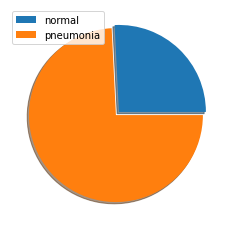

In [18]:
y = [len(normal), len(pneumonia)]
l = ["normal", "pneumonia"]
explode = (0.05, 0)  # explode 1st slice
patches, texts = plt.pie(y, explode=explode,  shadow=True )
plt.legend(patches, l, loc="best")
plt.show() 

#### 4. Size of the images

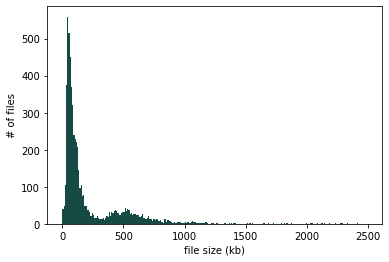

In [19]:

b = [i for i in range(0,2500,10)]

plt.xlabel('file size (kb)')
plt.ylabel('# of files')
plt.hist(sizes, bins=b,  color='#184A45FF')
plt.show()

Above is a histogram plot to show the ditribution of file sizes.  Most of the files are of size less than 1000 kb.

In [20]:
avg = sum(sizes)/len(sizes)
print(avg)

211.14802015027237


In [21]:
print(statistics.median(sizes))

95.839


In [22]:
print(min(sizes))

5.441


In [23]:
print(max(sizes))

2414.342


The mean file size is 211.148

The median file size is 95.839

The minimum file size observed is 5.441 kb

The maximum file size observed is 2412.342 kb

Sonce the file sizes are not all the same, some examination of the really small ans really large image files revealed that the really small images aspect ratio did not match those of the majority of images (i.e. they were longer in width than height and did not reveal the full chest/lung view).  These images might be considered outliers.  Further examination of the images below will attempt to exclude such outliers.  

#### 4. Aspect ratio of the images

The aspect ratio of an image is the ratio of its width to its height.
The formula is width / height.

Not all the images are of the same aspect ratio. On examining some of the images of smaller size, some did not show the full view of the chest and lungs.  We will remove these images.

If the shape of the image is longer in the x axis than it is in the y axis by certain threshold, then discard those images as they only show a section of the full chest image.

Choose something x/y must be less than or equal to 2 to constitute an acceptible image. (i.e. if the width is two or more times longer than the height then discard image)

In [24]:
temp_train_images = []
temp_train_labels = []

temp_test_images = []
temp_test_labels = []

discarded = []

for i in range(len(train_images)):
    xray = io.imread(train_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_train_images.append(train_images[i])
        temp_train_labels.append(train_labels[i])
    else:
        discarded.append(train_images[i])
        
for i in range(len(test_images)):
    xray = io.imread(test_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_test_images.append(test_images[i])
        temp_test_labels.append(test_labels[i])
    else:
        discarded.append(test_images[i])

In [25]:
print('updated train set, labels ', len(temp_train_images), len(temp_train_labels))
print('updated test set, labels ', len(temp_test_images), len(temp_test_labels))
print('discarded images ', len(discarded))

updated train set, labels  5116 5116
updated test set, labels  614 614
discarded images  126


Compare a discarded image to a remaining image in train set.

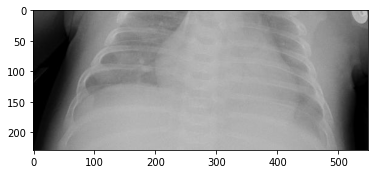

(229, 549, 3)


In [26]:
import matplotlib.pyplot as plt
im = io.imread(discarded[35])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

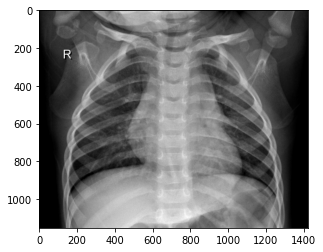

(1152, 1422)


In [27]:
im = io.imread(temp_train_images[1])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

#### 4. Redistribute data to a train/validation / test split of 85/15/15

Now that the outliers have been removed, we can redistribute the data set to add some more images to the test set to bring the value up to 15%, and then split the remaining test set into a test and validation split of 85/15.

We won't touch the images in the test set, rather we will simply move some of the ones from the train set into the test set.

Using 15% instead of 20% because we son't have that many images to work with.

In [28]:
# new ratios after removing some outliers

total = len(temp_train_images) + len(temp_test_images)
print('total images = ', total)

percent_test = len(temp_test_images)/total
print('percent test ', percent_test*100)

percent_train = len(temp_train_images)/total
print('percent train ', percent_train*100)

total images =  5730
percent test  10.715532286212914
percent train  89.28446771378708


In [29]:
# calculate number of images to move from train set to test set

needed = 0.15*total
print(needed)

have = len(temp_test_images)
print(have)

difference = needed - have
print("need to add an additional ", difference, " images")

859.5
614
need to add an additional  245.5  images


In [30]:
# convert to pandas dataframe

# train set
data_train = {'file':temp_train_images,'label':temp_train_labels}
train_df = pd.DataFrame(data_train)

# test set
data_test = {'file':temp_test_images,'label':temp_test_labels}
test_df = pd.DataFrame(data_test)

In [31]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
5111,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5112,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5113,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5114,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [32]:
train_df['file'][2000], train_df['label'][2000]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\train\\PNEUMONIA\\person1326_bacteria_3372.jpeg',
 'PNEUMONIA')

In [33]:
test_df['file'][200], test_df['label'][200]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0340-0001.jpeg',
 'NORMAL')

In [34]:
# first shuffle rows in train dataframe
train_df = train_df.sample(n = len(train_df), random_state=200).reset_index(drop=True)

In [35]:
# then move 245 rows from train dataframe to test dataframe
transferdata_df = train_df.iloc[-446:, 0:]

test_df = test_df.append(transferdata_df)

train_df = train_df.drop(transferdata_df.index)

In [36]:
# reset index of test_df
test_df = test_df.reset_index(drop=True)

In [37]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
4665,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4666,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4667,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4668,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [38]:
test_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
1055,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1056,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1057,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1058,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [39]:
# split train set further into train and validation set

newtrain_df = train_df.sample(frac=0.85,random_state=200) #random state is a seed value
validation_df = train_df.drop(newtrain_df.index)

In [40]:
train_df = newtrain_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [41]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
3965,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3966,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3967,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3968,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL


In [42]:
validation_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
695,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
696,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
697,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
698,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


We now have three data sets
- train_df (training set)
- validation_df (validation set)

- test_df (final test set)

#### 5. Shape and color of images

In [43]:
# Retrieving the geometry of the image and the number of pixels
# Images in scikit-image are represented by NumPy ndarrays. 
# Hence, many common operations can be achieved using standard NumPy methods for manipulating arrays

x = []
y = []
z = []
listofdataframes = [train_df, validation_df, test_df]

for df in listofdataframes:
    for index, row in df.iterrows():
        image = row['file']
        s = io.imread(image)
        x.append(s.shape[0])
        y.append(s.shape[1])
        if(len(s.shape) == 3):
            z.append(1)
        else:
            z.append(0)

In [44]:
df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z})

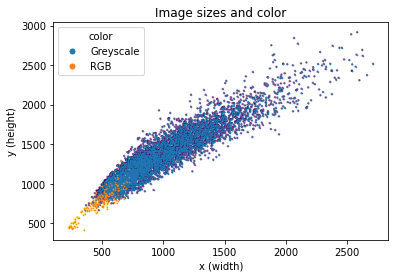

In [45]:
area = 2
plt.scatter(x, y, c=df.z, s=area,  alpha=0.5)
plt.title('Image sizes and color')
plt.xlabel('x (width)')
plt.ylabel('y (height)')
classes = [ 'Greyscale', 'RGB']
groups = df.groupby('z')
for name, group in groups:
    name = classes[0] if name == 0 else classes[1]
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=1, label=name)

plt.legend(title="color", markerscale=10)

plt.show()

 Since all the images are of different sizes, it will be necessary to reshape them to the same size.
 Also some are greyscale while other are RGB, so it will be necessary to normalize all images to the same color space (greyscale) 

## Data Preprocessing

The following steps need to be done in the data preprocessing step

- convert to greyscale
- grayscale normalization - to reduce the effect of illumination's differences.
Divide values by 255 to get a value between 0 and 1. NOTE: this already seems to be done automatically by scikit image

- image resize - to the same size - training, validation, and test set


In [46]:
from skimage.transform import resize

x_train_img = []
y_train_img = []

for i in tqdm(range(len(train_df))):
    img = resize(io.imread(train_df.loc[i,'file']), (128,128))
    x_train_img.append(img)
    y_train_img.append(0 if train_df.loc[i,'label'] == 'NORMAL' else 1)

100%|██████████████████████████████████████████████████████████████████████████████| 3970/3970 [03:00<00:00, 22.02it/s]


In [47]:
x_val_img = []
y_val_img = []

for i in tqdm(range(len(validation_df))):
    img = resize(io.imread(validation_df.loc[i,'file']), (128,128))
    x_val_img.append(img)
    y_val_img.append(0 if validation_df.loc[i,'label'] == 'NORMAL' else 1)

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:32<00:00, 21.79it/s]


In [48]:
x_test_img = []
y_test_img = []

for i in tqdm(range(len(test_df))):
    img = resize(io.imread(test_df.loc[i,'file']), (128,128))
    x_test_img.append(img)
    y_test_img.append(0 if test_df.loc[i,'label'] == 'NORMAL' else 1)

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:53<00:00, 19.93it/s]


In [49]:

from skimage.color import rgb2gray

for i in tqdm(range(len(x_train_img))):
    x_train_img[i] = rgb2gray(x_train_img[i])
    
for i in tqdm(range(len(x_val_img))):
    x_val_img[i] = rgb2gray(x_val_img[i])

for i in tqdm(range(len(x_test_img))):
    x_test_img[i] = rgb2gray(x_test_img[i])


  0%|                                                                                         | 0/3970 [00:00<?, ?it/s]c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.
  0%|                                                                                          | 0/700 [00:00<?, ?it/s]c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
  0%|                              

## Image Augmentation

- In order to avoid overfitting problem, alter the training data with small transformations. 
- Some popular augmentations people use are horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc. 
- By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

Flip images horizontally

In [50]:
x_train_img_fl = [np.flip(img,-1) for img in x_train_img]
x_val_img_fl = [np.flip(img,-1) for img in x_val_img]

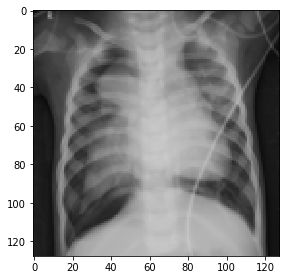

In [51]:
# verify flipped
io.imshow(x_train_img[0])

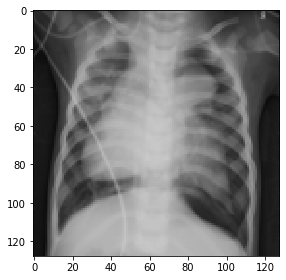

In [52]:
io.imshow(x_train_img_fl[0])

Crop then resize (simulate zoom)

In [53]:
from skimage.util import crop

x_train_img_cr = [resize(crop(i, (10), copy=False),(128,128)) for i in x_train_img]
x_val_img_cr = [resize(crop(i, (10), copy=False),(128,128)) for i in x_val_img]

In [54]:
# append zoomed images to train and validation sets

x_train_img = x_train_img + x_train_img_cr + x_train_img_fl
y_train_img = y_train_img + y_train_img + y_train_img
x_val_img = x_val_img + x_val_img_cr + x_val_img_fl
y_val_img = y_val_img + y_val_img + y_val_img


###  Calculate class weights

We will use the class_weights to correct for class imbalance to avoid a bias towards the majority class.

Formula to calculate the weight for a class

wj=n_samples / (n_classes * n_samplesj)

```text
wj is the weight for class j

n_samples is the total number of samples or rows in the dataset

n_classes is the total number of unique classes in the target

n_samplesj is the total number of rows of the respective class
```

In [55]:
normals = [i for i in y_train_img + y_val_img if i == 0]
print(len(normals))
pneumonias = [i for i in y_train_img + y_val_img if i == 1]
print(len(pneumonias))

3684
10326


In [56]:
n_samples = len(x_train_img) + len(x_val_img)
n_classes = 2
n_pneumonia = len(pneumonias)
n_normal = len(normals)

w_pneumonia = n_samples/(n_classes*n_pneumonia)
w_normal = n_samples/(n_classes*n_normal)

print("Number of pneumonia ", n_pneumonia, " and Number of normal ", n_normal)
print("weights: pneumonia = ", w_pneumonia, ", normal = ", w_normal)

# assign the class weights calculated above
# we will use this in the fit() method below

class_weight = {0: w_normal, 1: w_pneumonia}


Number of pneumonia  10326  and Number of normal  3684
weights: pneumonia =  0.678384660081348 , normal =  1.9014657980456027


In [57]:
def crossvalidate_roc(X, y, classifier, folds):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits=folds)
    X = np.array(X)
    y = np.array(y)
    
    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
    return mean_fpr, mean_tpr, mean_auc


## Model Selection Phase

In [58]:
x_train_img_flat = [np.array(i).flatten() for i in x_train_img]
x_val_img_flat = [np.array(i).flatten() for i in x_val_img]
x_test_img_flat = [np.array(i).flatten() for i in x_test_img]

In [59]:
# reduce dimensionality of the data using PCA to
# this will speed up training for classifiers like SVM which takes a long time

from sklearn.decomposition import PCA
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(x_train_img_flat + x_val_img_flat)
X_train_pca = pca.transform(x_train_img_flat + x_val_img_flat)

In [60]:
X_test_pca = pca.transform(x_test_img_flat)

In [61]:
x_tr = x_train_img_flat
x_val = x_val_img_flat
y_tr = y_train_img
y_val = y_val_img

### Baseline Model

In [62]:
# dictionary to hold fpr and tpr
roc = {}

In [63]:
clf_baseline = DummyClassifier(strategy="stratified")

In [64]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_baseline, X_train_pca, y_tr + y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 0.009198713302612304 0.000748189417326653
score_time 0.009200000762939453 0.0003998761810491959
test_accuracy 0.6135617416131334 0.006918104894483049
test_precision_weighted 0.611866687067218 0.006697088633300963
test_recall_weighted 0.6135617416131334 0.006918104894483049
test_f1_weighted 0.6126977744882692 0.006719285273896329
test_roc_auc 0.5010095988112526 0.014324572752920045


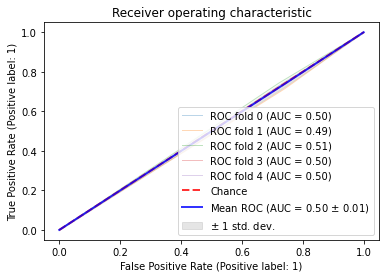

In [65]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_baseline, 5)
roc['baseline'] = [fpr,tpr,auc]

### Naive Bayes Classifier

In [66]:
clf_naive = GaussianNB()

In [67]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_naive, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 0.034799051284790036 0.0017211059721265163
score_time 0.023999929428100586 0.0018986117591910728
test_precision_weighted 0.80875118450832 0.014140841036164711
test_recall_weighted 0.7871520342612419 0.025429461384154566
test_f1_weighted 0.7937694628394223 0.02191972872644647
test_roc_auc 0.8579328110349442 0.02329141056295873


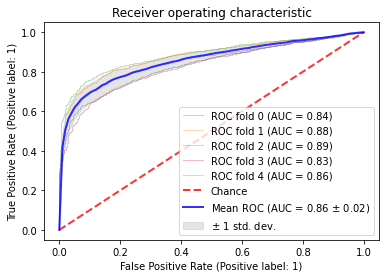

In [68]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_naive, 5)
roc['naive'] = [fpr,tpr,auc]

### Decision Tree Classifier

In [69]:
clf_dtree = tree.DecisionTreeClassifier()

In [70]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc']
scores = cross_validate(clf_dtree, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 2.8399120807647704 0.16816741535210153
score_time 0.011034870147705078 0.0019833061707864317
test_precision_weighted 0.8439546253841927 0.004196802536456492
test_recall_weighted 0.844039971448965 0.0033479056101523574
test_f1_weighted 0.8438319530949542 0.0035129838805332716
test_roc_auc 0.7978253435630149 0.008806034594056072


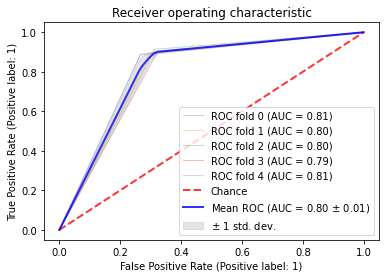

In [71]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_dtree, 5)
roc['decision tree'] = [fpr,tpr,auc]

### Random Forest Classifier

In [72]:
clf_randomforest = RandomForestClassifier(max_depth=2, random_state=0)

In [73]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc']
scores = cross_validate(clf_randomforest, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245

fit_time 1.7894690990448 0.010446459037804773
score_time 0.0445587158203125 0.004052222485541183
test_precision_weighted 0.5432353050563965 0.00021046453512099105
test_recall_weighted 0.7370449678800857 0.0001427551748751199
test_f1_weighted 0.6254706141470875 0.00019089835432009039
test_roc_auc 0.9072613428444625 0.00659152338886443


c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


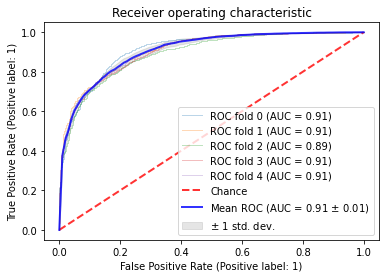

In [74]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_randomforest, 5)
roc['random forest'] = [fpr,tpr,auc]

### Support Vector Machine

In [75]:
clf_svm = svm.SVC()

In [76]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_svm, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 3.1661684036254885 0.014314348970370488
score_time 2.7357316970825196 0.017735524193781053
test_precision_weighted 0.9623690278578018 0.0042907807373868765
test_recall_weighted 0.9624553890078517 0.0042552058703180145
test_f1_weighted 0.9622185907340743 0.0044521559314755765
test_roc_auc 0.992043275164092 0.001133149198596408


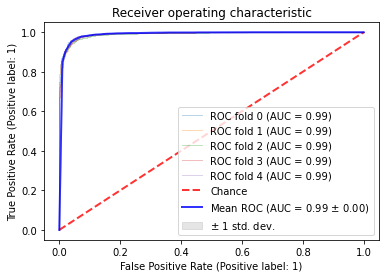

In [77]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_svm, 5)
roc['support vector machine'] = [fpr,tpr,auc]

### Plot combined ROC curves

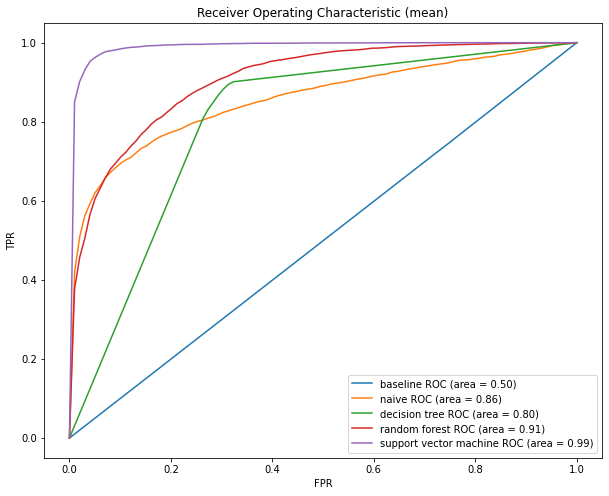

In [78]:
plt.figure(figsize=(10,8))
for key, value in roc.items():
    plt.plot(value[0], value[1], label='%s ROC (area = %0.2f)' % (key, value[2]))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic (mean)')
plt.show()

## Hyperparameter tuning

In [79]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[0.5, 1.0, 1.5, 1.75, 2, 2.25, 2.5, 5, 10]}
clf_ = GridSearchCV(svm.SVC(class_weight='balanced'), parameters, cv=5)
search = clf_.fit(X_train_pca, y_tr + y_val)
print(search.best_params_)

{'C': 10, 'kernel': 'rbf'}


### Evaluate Final Model on Test Set

In [80]:
clf_svm_final = svm.SVC(C=search.best_params_['C'], kernel=search.best_params_['kernel'], class_weight='balanced')

In [81]:
clf_svm_final.fit(X_train_pca, y_tr + y_val)

SVC(C=10, class_weight='balanced')

In [82]:
#p = np.array(clf_svm_final.decision_function(x_test))
#prob = np.exp(p)/np.sum(np.exp(p), keepdims=True)
pred_svm_final = clf_svm.predict(X_test_pca)
print(classification_report(y_test_img, pred_svm_final))

              precision    recall  f1-score   support

           0       0.97      0.55      0.70       353
           1       0.82      0.99      0.89       707

    accuracy                           0.84      1060
   macro avg       0.89      0.77      0.80      1060
weighted avg       0.87      0.84      0.83      1060



confusion matrix
[[195 158]
 [  7 700]]


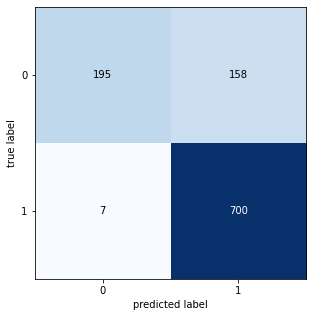

In [83]:
#CM_svm_final = confusion_matrix(test_set.classes, np.argmax(pred_svm_final, axis=1))
CM_svm_final = confusion_matrix(y_test_img, pred_svm_final)
print("confusion matrix")
print(CM_svm_final)
fig, ax = plot_confusion_matrix(conf_mat=CM_svm_final ,  figsize=(5, 5))
plt.show()

In [84]:
#pred_svm = clf_svm.predict(x_test)
# example to get probablitites for SVM
#p = np.array(clf_svm.decision_function(x_test))
#prob = np.exp(p)/np.sum(np.exp(p), keepdims=True)

#fpr, tpr, thresholds = metrics.roc_curve(y_test, prob)  # you have to pass the probabilities here
#auc = metrics.roc_auc_score(y_test, pred_svm)
#roc['svm'] = [fpr,tpr,auc]

#plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('svm', auc))
#plt.legend(loc=0)

## Deep Neural Nets

### Define Metrics

In [85]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

### Define Cross validation function

In [86]:
def kfoldcrossval(x, y, folds, epochs, model):
    
    losses = {}
    val_losses = {}
    accuracies = {}
    val_accuracies = {}
    
    skf = StratifiedKFold(n_splits=folds, random_state=0, shuffle=True)
    for train, test in skf.split(x,y):
        #print("TRAIN:", train, "TeST: ", test)
        
        train_x = list();
        train_y = list();
        test_x = list();
        test_y = list();
        
        for train_index in train:
            train_x.append(x[train_index])
            train_y.append(y[train_index])
        
        for test_index in test:
            test_x.append(x[test_index])
            test_y.append(y[test_index])            
        
        with tf.device(device_spec):
            history = model.fit(np.array(train_x), np.array(train_y), batch_size=32, epochs=epochs, class_weight=class_weight, validation_data=(np.array(test_x), np.array(test_y)), verbose=1)
        
            history_df = pd.DataFrame(history.history)

            for i in range(0, len(history_df)):

                if i in losses:
                    losses[i].append(history_df['loss'][i])
                else:
                    losses[i] = []
                    losses[i].append(history_df['loss'][i])

                if i in val_losses:
                    val_losses[i].append(history_df['val_loss'][i])
                else:
                    val_losses[i] = []
                    val_losses[i].append(history_df['val_loss'][i])

                if i in accuracies:
                    accuracies[i].append(history_df['accuracy'][i])
                else:
                    accuracies[i] = []
                    accuracies[i].append(history_df['accuracy'][i])

                if i in val_accuracies:
                    val_accuracies[i].append(history_df['val_accuracy'][i])
                else:
                    val_accuracies[i] = []
                    val_accuracies[i].append(history_df['val_accuracy'][i])                
        
    return losses, val_losses, accuracies, val_accuracies


### Building CNN-1

In [165]:
cnn_1 = tf.keras.models.Sequential(name='cnn_1')
#cnn_1.add(tf.keras.layers.Cropping2D(cropping=((8, 8), (8, 8)), input_shape=(256,256,1)))

#### 1. Convolution and Pooling

In [166]:
#cnn_1.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu' ))
cnn_1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(128,128, 1) ))
#cnn_1.add(tf.keras.layers.BatchNormalization())
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
#cnn_1.add(tf.keras.layers.BatchNormalization())

#### 3. Add a additional Convolutional and Pooling Layer

In [167]:
#cnn.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation='relu'))
#cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
cnn_1.add(tf.keras.layers.Dropout(0.2))

cnn_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
#cnn_1.add(tf.keras.layers.BatchNormalization())
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
#cnn_1.add(tf.keras.layers.BatchNormalization())
cnn_1.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
#cnn_1.add(tf.keras.layers.BatchNormalization())
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))

#### 4. Flattening

In [168]:
cnn_1.add(tf.keras.layers.Flatten())

#### 5. Full Connection

In [169]:
#units = number of hidden neurons - larger number better for images
cnn_1.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l=0.01)))
#cnn_1.add(tf.keras.layers.BatchNormalization())
cnn_1.add(tf.keras.layers.Dropout(0.5))

#### 6. Output Layer

In [170]:
#units = 1 for binary classification
cnn_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### 7. Compiling the CNN

In [171]:
cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
cnn_1.summary()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 128)       36992     
________________________________________________________

### Building CNN-2

In [94]:
cnn_2 = tf.keras.models.Sequential(name='cnn_2')
#cnn_2.add(tf.keras.layers.Cropping2D(cropping=((8, 8), (8, 8)), input_shape=(256,256,1)))
cnn_2.add(tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(128,128,1) ))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.1))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.3))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.3))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Flatten())

cnn_2.add(tf.keras.layers.Dense(units = 128 , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.007)))
cnn_2.add(tf.keras.layers.Dropout(0.5))

a = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')
cnn_2.add(tf.keras.layers.Dense(units = 1 , activation = a))
cnn_2.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = METRICS)
cnn_2.summary()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
________________________________________________________

In [95]:
# reshape the images to fit the input  layers

In [96]:
xtr = [resize(img, (128,128,1)) for img in x_train_img]

In [97]:
xval = [resize(img, (128,128,1)) for img in x_val_img]

#### 3.1 Training CNN-1

In [172]:
# NOTE - cannot use the validation_split when using data set generators so need to split the dataframe manually
# into train and validation set. This was done above

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, restore_best_weights=True)
#history = cnn.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=100, callbacks=[callback] )

#history_cnn_1 = cnn_1.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=50 )

losses_1, val_losses_1, accuracies_1, val_accuracies_1 = kfoldcrossval(xtr + xval, y_tr + y_val, 5, 25, cnn_1)

Epoch 1/25
351/351 [==============================] - 10s 27ms/step - loss: 29.8830 - accuracy: 0.5053 - precision: 0.7701 - recall: 0.5934 - auc: 0.6252 - val_loss: 5.2531 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/25
351/351 [==============================] - 9s 26ms/step - loss: 5.1795 - accuracy: 0.6647 - precision: 0.7423 - recall: 0.8411 - auc: 0.4924 - val_loss: 5.2597 - val_accuracy: 0.2627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/25
351/351 [==============================] - 9s 26ms/step - loss: 5.1380 - accuracy: 0.4919 - precision: 0.7386 - recall: 0.4878 - auc: 0.4944 - val_loss: 5.0804 - val_accuracy: 0.2627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6107
Epoch 4/25
351/351 [==============================] - 9s 26ms/step - loss: 5.1071 - accuracy: 0.4386 - precision: 0.7357 - recall: 0.3691 - auc: 0.4956 - val_loss: 5.0953 - val_accuracy: 0.7373 - val_precision: 

Epoch 8/25
351/351 [==============================] - 9s 26ms/step - loss: 4.6981 - accuracy: 0.9179 - precision: 0.9690 - recall: 0.9180 - auc: 0.9716 - val_loss: 4.5518 - val_accuracy: 0.9268 - val_precision: 0.9750 - val_recall: 0.9245 - val_auc: 0.9843
Epoch 9/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6917 - accuracy: 0.9163 - precision: 0.9683 - recall: 0.9165 - auc: 0.9716 - val_loss: 4.6570 - val_accuracy: 0.9361 - val_precision: 0.9734 - val_recall: 0.9390 - val_auc: 0.9847
Epoch 10/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6981 - accuracy: 0.9139 - precision: 0.9654 - recall: 0.9160 - auc: 0.9704 - val_loss: 4.7696 - val_accuracy: 0.8779 - val_precision: 0.9931 - val_recall: 0.8402 - val_auc: 0.9841
Epoch 11/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6871 - accuracy: 0.9159 - precision: 0.9691 - recall: 0.9150 - auc: 0.9727 - val_loss: 4.6546 - val_accuracy: 0.9411 - val_precision: 0.9803 - val_rec

Epoch 15/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6675 - accuracy: 0.9309 - precision: 0.9790 - recall: 0.9262 - auc: 0.9801 - val_loss: 4.5929 - val_accuracy: 0.9468 - val_precision: 0.9733 - val_recall: 0.9540 - val_auc: 0.9860
Epoch 16/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6522 - accuracy: 0.9324 - precision: 0.9803 - recall: 0.9269 - auc: 0.9812 - val_loss: 4.5610 - val_accuracy: 0.9493 - val_precision: 0.9810 - val_recall: 0.9496 - val_auc: 0.9895
Epoch 17/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6605 - accuracy: 0.9291 - precision: 0.9792 - recall: 0.9234 - auc: 0.9801 - val_loss: 4.6495 - val_accuracy: 0.9554 - val_precision: 0.9727 - val_recall: 0.9666 - val_auc: 0.9905
Epoch 18/25
351/351 [==============================] - 9s 25ms/step - loss: 4.6568 - accuracy: 0.9292 - precision: 0.9790 - recall: 0.9237 - auc: 0.9805 - val_loss: 4.6323 - val_accuracy: 0.9379 - val_precision: 0.9866 - val_r

351/351 [==============================] - 9s 27ms/step - loss: 4.6486 - accuracy: 0.9315 - precision: 0.9816 - recall: 0.9243 - auc: 0.9808 - val_loss: 4.4833 - val_accuracy: 0.9643 - val_precision: 0.9842 - val_recall: 0.9671 - val_auc: 0.9927
Epoch 22/25
351/351 [==============================] - 9s 26ms/step - loss: 4.6392 - accuracy: 0.9343 - precision: 0.9842 - recall: 0.9258 - auc: 0.9815 - val_loss: 4.7213 - val_accuracy: 0.9240 - val_precision: 0.9915 - val_recall: 0.9046 - val_auc: 0.9905
Epoch 23/25
351/351 [==============================] - 9s 26ms/step - loss: 4.6395 - accuracy: 0.9336 - precision: 0.9835 - recall: 0.9254 - auc: 0.9822 - val_loss: 4.5818 - val_accuracy: 0.9479 - val_precision: 0.9848 - val_recall: 0.9438 - val_auc: 0.9898
Epoch 24/25
351/351 [==============================] - 9s 26ms/step - loss: 4.6357 - accuracy: 0.9312 - precision: 0.9827 - recall: 0.9229 - auc: 0.9822 - val_loss: 4.6357 - val_accuracy: 0.9665 - val_precision: 0.9727 - val_recall: 0.982

#### 3.2 Train CNN-2

In [99]:
#history_cnn_2 = cnn_2.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=50 )

In [100]:
losses_2, val_losses_2, accuracies_2, val_accuracies_2 = kfoldcrossval(xtr + xval, y_tr + y_val, 5, 50, cnn_2)

Epoch 1/50
351/351 [==============================] - 12s 29ms/step - loss: 0.8262 - accuracy: 0.5984 - precision: 0.8763 - recall: 0.3328 - auc: 0.6963 - val_loss: 0.3126 - val_accuracy: 0.9133 - val_precision: 0.9053 - val_recall: 0.9855 - val_auc: 0.9758
Epoch 2/50
351/351 [==============================] - 9s 27ms/step - loss: 0.2200 - accuracy: 0.9308 - precision: 0.9804 - recall: 0.9249 - auc: 0.9808 - val_loss: 0.2150 - val_accuracy: 0.9336 - val_precision: 0.9942 - val_recall: 0.9153 - val_auc: 0.9930
Epoch 3/50
351/351 [==============================] - 9s 27ms/step - loss: 0.1653 - accuracy: 0.9519 - precision: 0.9857 - recall: 0.9483 - auc: 0.9895 - val_loss: 0.1379 - val_accuracy: 0.9661 - val_precision: 0.9843 - val_recall: 0.9695 - val_auc: 0.9940
Epoch 4/50
351/351 [==============================] - 10s 28ms/step - loss: 0.1664 - accuracy: 0.9488 - precision: 0.9825 - recall: 0.9476 - auc: 0.9889 - val_loss: 0.1389 - val_accuracy: 0.9682 - val_precision: 0.9935 - val_rec

Epoch 33/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0497 - accuracy: 0.9913 - precision: 0.9971 - recall: 0.9911 - auc: 0.9991 - val_loss: 0.0852 - val_accuracy: 0.9818 - val_precision: 0.9907 - val_recall: 0.9845 - val_auc: 0.9963
Epoch 34/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0438 - accuracy: 0.9929 - precision: 0.9982 - recall: 0.9921 - auc: 0.9993 - val_loss: 0.1043 - val_accuracy: 0.9750 - val_precision: 0.9955 - val_recall: 0.9705 - val_auc: 0.9954
Epoch 35/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0505 - accuracy: 0.9903 - precision: 0.9974 - recall: 0.9895 - auc: 0.9994 - val_loss: 0.0745 - val_accuracy: 0.9825 - val_precision: 0.9828 - val_recall: 0.9937 - val_auc: 0.9963
Epoch 36/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0341 - accuracy: 0.9945 - precision: 0.9984 - recall: 0.9942 - auc: 0.9997 - val_loss: 0.1130 - val_accuracy: 0.9693 - val_precision: 0.9960 - val_

Epoch 15/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0376 - accuracy: 0.9946 - precision: 0.9982 - recall: 0.9944 - auc: 0.9996 - val_loss: 0.0326 - val_accuracy: 0.9975 - val_precision: 0.9985 - val_recall: 0.9981 - val_auc: 1.0000
Epoch 16/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0413 - accuracy: 0.9933 - precision: 0.9978 - recall: 0.9931 - auc: 0.9994 - val_loss: 0.0376 - val_accuracy: 0.9939 - val_precision: 1.0000 - val_recall: 0.9918 - val_auc: 1.0000
Epoch 17/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0330 - accuracy: 0.9956 - precision: 0.9987 - recall: 0.9954 - auc: 0.9998 - val_loss: 0.0383 - val_accuracy: 0.9907 - val_precision: 1.0000 - val_recall: 0.9874 - val_auc: 1.0000
Epoch 18/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0355 - accuracy: 0.9942 - precision: 0.9982 - recall: 0.9939 - auc: 0.9996 - val_loss: 0.0397 - val_accuracy: 0.9911 - val_precision: 0.9923 - val_

351/351 [==============================] - 10s 27ms/step - loss: 0.0326 - accuracy: 0.9968 - precision: 0.9990 - recall: 0.9966 - auc: 0.9997 - val_loss: 0.0294 - val_accuracy: 0.9943 - val_precision: 0.9985 - val_recall: 0.9937 - val_auc: 0.9999
Epoch 47/50
351/351 [==============================] - 9s 27ms/step - loss: 0.0422 - accuracy: 0.9945 - precision: 0.9981 - recall: 0.9944 - auc: 0.9991 - val_loss: 0.0603 - val_accuracy: 0.9893 - val_precision: 0.9947 - val_recall: 0.9908 - val_auc: 0.9991
Epoch 48/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0276 - accuracy: 0.9978 - precision: 0.9993 - recall: 0.9977 - auc: 0.9999 - val_loss: 0.0577 - val_accuracy: 0.9875 - val_precision: 0.9980 - val_recall: 0.9850 - val_auc: 0.9986
Epoch 49/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0296 - accuracy: 0.9969 - precision: 0.9992 - recall: 0.9966 - auc: 0.9997 - val_loss: 0.0407 - val_accuracy: 0.9929 - val_precision: 0.9976 - val_recall: 0.

Epoch 28/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0254 - accuracy: 0.9975 - precision: 0.9990 - recall: 0.9976 - auc: 0.9998 - val_loss: 0.0214 - val_accuracy: 0.9989 - val_precision: 1.0000 - val_recall: 0.9985 - val_auc: 1.0000
Epoch 29/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0138 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9990 - auc: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9993 - val_precision: 1.0000 - val_recall: 0.9990 - val_auc: 1.0000
Epoch 30/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0212 - accuracy: 0.9967 - precision: 0.9987 - recall: 0.9969 - auc: 0.9999 - val_loss: 0.0246 - val_accuracy: 0.9982 - val_precision: 0.9995 - val_recall: 0.9981 - val_auc: 1.0000
Epoch 31/50
351/351 [==============================] - 10s 28ms/step - loss: 0.0341 - accuracy: 0.9963 - precision: 0.9987 - recall: 0.9964 - auc: 0.9997 - val_loss: 0.0397 - val_accuracy: 0.9961 - val_precision: 0.9957 - v

Epoch 10/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0198 - accuracy: 0.9984 - precision: 0.9994 - recall: 0.9984 - auc: 0.9999 - val_loss: 0.0179 - val_accuracy: 0.9989 - val_precision: 0.9995 - val_recall: 0.9990 - val_auc: 1.0000
Epoch 11/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0192 - accuracy: 0.9983 - precision: 0.9993 - recall: 0.9984 - auc: 0.9999 - val_loss: 0.0206 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 12/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0251 - accuracy: 0.9979 - precision: 0.9990 - recall: 0.9981 - auc: 0.9997 - val_loss: 0.0163 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0318 - accuracy: 0.9953 - precision: 0.9979 - recall: 0.9956 - auc: 0.9996 - val_loss: 0.0348 - val_accuracy: 0.9975 - val_precision: 1.0000 - v

351/351 [==============================] - 10s 27ms/step - loss: 0.0123 - accuracy: 0.9993 - precision: 0.9998 - recall: 0.9993 - auc: 0.9999 - val_loss: 0.0161 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 42/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9990 - recall: 0.9984 - auc: 0.9997 - val_loss: 0.0230 - val_accuracy: 0.9986 - val_precision: 0.9995 - val_recall: 0.9985 - val_auc: 0.9997
Epoch 43/50
351/351 [==============================] - 10s 28ms/step - loss: 0.0226 - accuracy: 0.9973 - precision: 0.9989 - recall: 0.9975 - auc: 0.9998 - val_loss: 0.0365 - val_accuracy: 0.9946 - val_precision: 0.9928 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 44/50
351/351 [==============================] - 10s 28ms/step - loss: 0.0265 - accuracy: 0.9980 - precision: 0.9994 - recall: 0.9979 - auc: 0.9995 - val_loss: 0.0135 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1

Epoch 23/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0194 - accuracy: 0.9987 - precision: 0.9996 - recall: 0.9985 - auc: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 0.9995 - val_auc: 1.0000
Epoch 24/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0252 - accuracy: 0.9981 - precision: 0.9990 - recall: 0.9984 - auc: 0.9994 - val_loss: 0.0214 - val_accuracy: 0.9996 - val_precision: 0.9995 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 25/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0280 - accuracy: 0.9979 - precision: 0.9992 - recall: 0.9981 - auc: 0.9997 - val_loss: 0.0165 - val_accuracy: 0.9996 - val_precision: 0.9995 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 26/50
351/351 [==============================] - 10s 27ms/step - loss: 0.0170 - accuracy: 0.9990 - precision: 0.9996 - recall: 0.9990 - auc: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9993 - val_precision: 0.9990 - v

### Evaluating

#### 1. Examine the loss and accuracy curves

In [101]:
def getAverages(losses, val_losses, accuracies, val_accuracies):
    avg_losses = []
    max_losses = []
    avg_val_losses = []

    for i in range(len(losses)):
        avg_losses.append(statistics.mean(losses[i]))
        max_losses.append(max(losses[i]))
        avg_val_losses.append(statistics.mean(val_losses[i])) 

    avg_accuracies = []
    avg_val_accuracies = []

    for i in range(len(accuracies)):
        avg_accuracies.append(statistics.mean(accuracies[i]))
        avg_val_accuracies.append(statistics.mean(val_accuracies[i])) 
    
    return avg_losses, avg_val_losses, avg_accuracies, avg_val_accuracies

In [124]:
def plotLossAccuracyCurves(avg_losses, avg_val_losses, avg_accuracies, avg_val_accuracies):
    plt.figure(figsize=(20,5))
    
    e = [i for i in range(len(avg_losses))]

    # plot loss & val loss
    plt.subplot(1,2,1)
    sns.lineplot(x=e, y=avg_losses, color='red', label='avg train Loss')
    sns.lineplot(x=e, y=avg_val_losses, color='orange', label='avg val Loss')
    plt.title('avg Loss on train vs validation')
    plt.legend(loc='best')

    # plot accuracy and val accuracy
    plt.subplot(1,2,2)
    sns.lineplot(x=e, y=avg_accuracies, color='blue', label='avg Train Accuracy')
    sns.lineplot(x=e, y=avg_val_accuracies, color='green', label='avg Val Accuracy')
    plt.title('avg Accuracy on train vs validation')
    plt.legend(loc='best')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

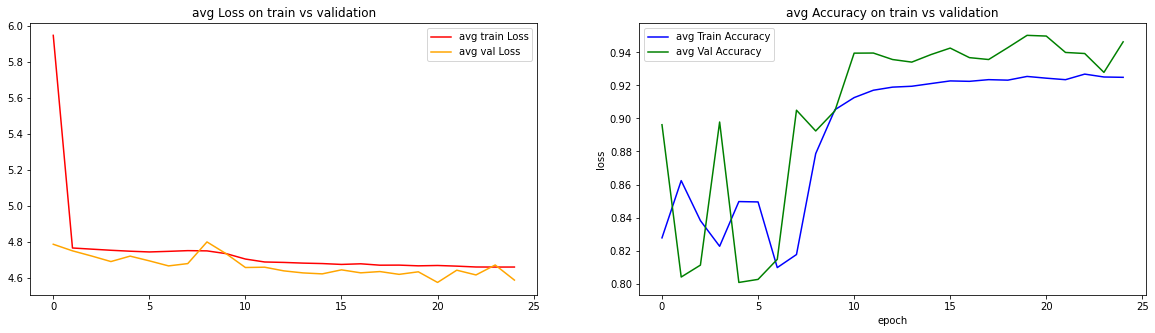

In [173]:
l, vl, a, va = getAverages(losses_1, val_losses_1, accuracies_1, val_accuracies_1)
plotLossAccuracyCurves(l, vl, a, va)

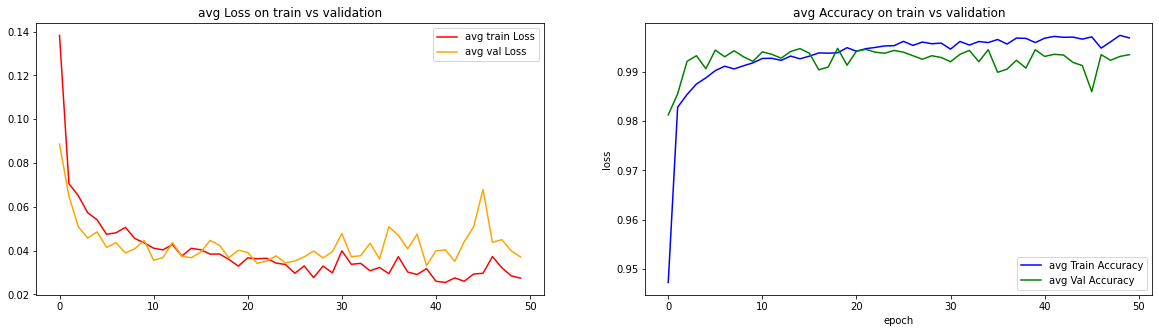

In [127]:
l, vl, a, va = getAverages(losses_2, val_losses_2, accuracies_2, val_accuracies_2)
plotLossAccuracyCurves(l, vl, a, va)

#### 2.1 Evaluate performance of the CNN-1 model on the test set

In [174]:
t = np.array(x_test_img)
t = t.reshape(1060, 128, 128,1)
t.shape

(1060, 128, 128, 1)

In [175]:
print("metrics on validation set")
test_accu = cnn_1.evaluate(t, np.array(y_test_img))
print(test_accu)

metrics on validation set
34/34 [==============================] - 0s 9ms/step - loss: 4.9633 - accuracy: 0.8604 - precision: 0.8534 - recall: 0.9547 - auc: 0.9174    
[4.9633097648620605, 0.8603773713111877, 0.8533501625061035, 0.9547383189201355, 0.9173981547355652]


In [176]:
test_labels = y_test_img

predicting...
34/34 [==============================] - 0s 4ms/step
number of predictions  1060
classification report
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       353
           1       0.85      0.95      0.90       707

    accuracy                           0.86      1060
   macro avg       0.87      0.81      0.83      1060
weighted avg       0.86      0.86      0.85      1060

confusion matrix
[[237 116]
 [ 32 675]]


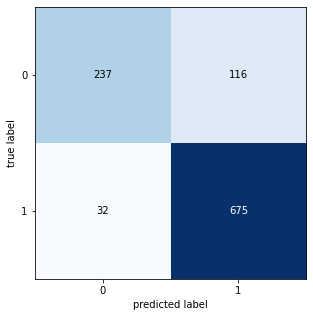

In [177]:
# predict the probability distribution of the data

# WARNING:tensorflow:From <ipython-input-72-9913226a8330>:3: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
# Instructions for updating:
# Please use instead:* 
# `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* 
# `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

print("predicting...")
predictions_cnn_1 = (cnn_1.predict(t, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_1))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_1))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_labels, predictions_cnn_1)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

#### 2.2 Evaluate performance of CNN-2 model on Test Set

In [151]:
print("cnn2 metrics on test set")
test_accu = cnn_2.evaluate(t, np.array(y_test_img))
print(test_accu)

cnn2 metrics on test set
34/34 [==============================] - 0s 11ms/step - loss: 1.7946 - accuracy: 0.8840 - precision: 0.8561 - recall: 0.9929 - auc: 0.8694   
[1.794611930847168, 0.8839622735977173, 0.8560975790023804, 0.9929278492927551, 0.8693798780441284]


predicting...
34/34 [==============================] - 0s 6ms/step
number of predictions  1060
classification report
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       353
           1       0.86      0.99      0.92       707

    accuracy                           0.88      1060
   macro avg       0.92      0.83      0.86      1060
weighted avg       0.90      0.88      0.88      1060

confusion matrix
[[235 118]
 [  5 702]]


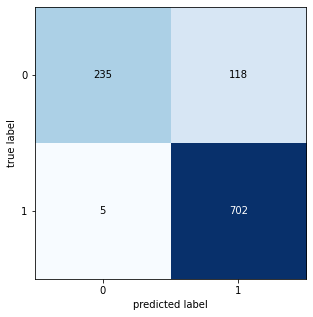

In [153]:
print("predicting...")
predictions_cnn_2 = (cnn_2.predict(t, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_2))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_2))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_labels, predictions_cnn_2)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### Make a Prediction

In [ ]:
#from PIL import Image
import numpy as np
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
def load(filename):
    #np_image = Image.open(filename)
    np_image = io.imread(filename)
    np_image = rgb2gray(np_image)/255
    #np_image = np.array(np_image).astype('float32')

    np_image = transform.resize(np_image, (128, 128, 1))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load(r'E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\assignment\data\chest_xray\train\PNEUMONIA\person438_bacteria_1889.jpeg')

In [ ]:
print( cnn_2.predict_classes(image), cnn_2.predict_proba(image)*100, '%')

# The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.